In [4]:
print(sc.uiWebUrl)

http://midway3-0078.rcc.local:4040


In [1]:
! squeue -u yjia2

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41640697   caslake _interac    yjia2  R      49:53      1 midway3-0078


In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = "/home/yjia2/fonts/NotoSansCJKsc-Regular.otf"  
fm.fontManager.addfont(font_path)
zh_font = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = zh_font.get_name()
plt.rcParams["axes.unicode_minus"] = False

In [ ]:
from pyspark.sql import functions as F, types as T
from pyspark.ml.functions import vector_to_array
from sklearn.neighbors import NearestNeighbors
from pyspark.storagelevel import StorageLevel
from pyspark.ml.feature import Word2VecModel
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.feature import Word2Vec
from dask_jobqueue import SLURMCluster
from pyspark.sql import SparkSession
from dask.distributed import Client
from pyspark.ml.feature import PCA
import dask.delayed as delayed
from node2vec import Node2Vec
from pyspark.sql import Row
import networkx as nx
import pandas as pd
import numpy as np
import dask

# Investigate the Method's Current Usage

Peng et al. (2024) demonstrated that node2vec can serve as an effective graph-based representation method applicable to a wider range of political classification tasks. In their stance detection research, they constructed a user-tweet interaction graph and used network embeddings to capture polarization patterns that cannot be revealed by textual data alone. Although node2vec primarily appeared as a baseline method in their study, their results confirmed a key methodological insight: political meaning often exists not only in linguistic content but also in the relational structures between actors. This reinforces the intuition behind my project—that understanding political concepts in the People's Daily requires modeling the interrelationships of words within a larger semantic network, rather than relying solely on superficial co-occurrence relationships.

Yang and Fu (2024) further argued for the value of node2vec, positioning it as a core tool for revealing the ideological structure in Chinese Wikipedia. They constructed a PMI-weighted bipartite graph of editorial and political articles and used node2vec to embed nodes into a shared structural space, then used PCA and ICA to decompose the embeddings to identify potential ideological axes. Their research demonstrates that node2vec excels in scenarios where macro-political patterns emerge from micro-relational data—a dynamic that aligns perfectly with my own research objectives: tracking how concepts such as “people,” “nation,” and “democracy” evolve within ever-changing semantic structures throughout history.

Brown et al. (2021) further elaborated on these applications by systematically outlining network embedding methods, including node2vec, and assessing their advantages in political science research. Their discussion highlights node2vec’s ability to simultaneously capture local neighborhood similarities and global graph topology, making it particularly suitable for large-scale relational reasoning tasks. Importantly, they emphasize the method’s flexibility in exploratory analysis and formal modeling.

In summary, these studies establish node2vec as a widely adopted and theoretically sound approach capable of extracting political structures from complex networks. Their findings directly inform my project, validating node2vec’s application in analyzing the conceptual evolution of the People’s Daily and demonstrating how graph embedding can serve simultaneously as an analytical tool and a powerful exploratory data analysis (EDA) technique for large historical corpora.

Peng, W., Zhang, M., Zhang, Y., & Liu, X. (2024). Online social behavior enhanced detection of political stances in tweets. Proceedings of the International AAAI Conference on Web and Social Media (ICWSM 2024).

Yang, H., & Fu, K. (2024). Unsupervised learning methods reveal the complexity of user segregation in the political sphere: The case of Chinese Wikipedia editors. Procedia Computer Science, 234, 123–134.

Brown, M. A., Terechshenko, Z., Connolly, R., Lai, A., Ji, C., Nagler, J., Tucker, J. A., & Bonneau, R. (2021). Network embedding methods for large networks in political science. 

# Test the Method on Your Data

In my project, I chose to introduce Node2Vec after the annual Word2Vec dataset primarily because it can supplement the "structural semantic information" that Word2Vec cannot provide. Training Word2Vec year by year allows me to observe changes in the semantic similarity of political concepts across different historical periods, but Word2Vec essentially only reflects local co-occurrence contexts and cannot tell me the structural position of these concepts within the overall annual semantic system. For example, "people" might have a high similarity to "country" and "government" in a particular year, but I cannot determine whether it is a core node, a peripheral node, or a bridge connecting different semantic clusters in the semantic network based solely on similarity. The political discourse of the People's Daily is highly structured, where different concepts not only move closer or further apart but also exhibit more complex network relationships. **Therefore, constructing a semantic graph from the annual word vectors and then using Node2Vec to learn embeddings from the graph structure is a necessary extension, enabling me to capture the overall structural drift of concepts within the semantic system, rather than just changes in local similarity**.

My overall workflow is as follows:
- Annual Corpus Segmentation and Year-by-Year Training of Word2Vec

- Constructing a Semantic Network Based on Annual Word Vectors and Training Node2Vec

- Spatial Alignment of Cross-Year Semantic Embeddings

- Distant Structure and Semantic Analysis of Key Political Concepts

### Annual Corpus Segmentation and Year-by-Year Training of Word2Vec

My first step was to segment the People's Daily corpus by year and train a separate Word2Vec model for each year. The purpose of this part was to create comparable but structurally independent semantic spaces for political concepts at different historical stages, enabling me to capture the semantic changes of keywords such as "people" in the local context of each year, while avoiding biases caused by differences in the distribution of texts across different eras.

In [12]:
# Pre-processing

BASE_PATH = "cleaned_segmented_parquet"

df_raw = spark.read.parquet(BASE_PATH)

df = (
    df_raw
    .withColumnRenamed("文本内容_清洗", "content_cleaned")
    .withColumnRenamed("年份", "year")
    .select("content_cleaned", "year")
)

df = df.withColumn("year", F.col("year").cast("int"))

df = (
    df
    .withColumn("content_cleaned", F.trim(F.col("content_cleaned")))
    .filter(
        F.col("content_cleaned").isNotNull()
        & (F.length("content_cleaned") > 0)
    )
)

df = (
    df
    .withColumn("tokens", F.split(F.col("content_cleaned"), r"\s+"))
    .withColumn("tokens", F.expr("filter(tokens, x -> x <> '')"))
)

df = (
    df
    .withColumn("len_tokens", F.size("tokens"))
    .filter(F.col("len_tokens") >= 3)
    .drop("len_tokens")
)

year_stats = (
    df.groupBy("year")
      .agg(
          F.count("*").alias("n_docs"),
          F.sum(F.size("tokens")).alias("n_tokens")
      )
      .orderBy("year")
)

year_stats.show(1, truncate=False)


[Stage 2:======================================================>(249 + 2) / 251]

+----+------+--------+
|year|n_docs|n_tokens|
+----+------+--------+
|1947|10769 |2711874 |
+----+------+--------+
only showing top 1 row



In [8]:
# Word2Vec hyper-parameters 
W2V_PARAMS = dict(
    vectorSize=150,
    windowSize=6,
    minCount=30,
    maxIter=3,          # epochs
    stepSize=0.025,     # learning rate
    numPartitions=100,
    maxSentenceLength=600,
    seed=42,
    inputCol="tokens",
    outputCol="w2v_features"
)

BASE_MODEL_DIR = "w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year"

In [9]:
years = (
    df.select("year")
      .distinct()
      .orderBy("year")
      .rdd.map(lambda r: r["year"])
      .collect()
)

print("Years to train:", years[:10], "... total =", len(years))

[Stage 24:>                                                         (0 + 1) / 1]

Years to train: [1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956] ... total = 78


In [ ]:
MIN_DOCS = 500

for y in years:
    print(f"\n===== Training year {y} =====")

    df_y = (
        df.filter(F.col("year") == y)
          .select("tokens")
    )

    n_docs = df_y.count()
    print(f"Docs in {y} = {n_docs}")

    if n_docs < MIN_DOCS:
        print(f"Skip {y} (n_docs < MIN_DOCS={MIN_DOCS})")
        continue

    df_y_train = df_y.repartition(100).persist(StorageLevel.MEMORY_AND_DISK)
    _ = df_y_train.count()   
    print(f"{y}: cached training corpus")

    w2v = Word2Vec(**W2V_PARAMS)
    w2v_model = w2v.fit(df_y_train)
    print(f"{y}: model trained")

    df_y_train.unpersist()

    model_dir = f"{BASE_MODEL_DIR}/year={y}"
    print(f"{y}: saving model to {model_dir}")
    w2v_model.write().overwrite().save(model_dir)

    vecs = w2v_model.getVectors()   # DataFrame[word: string, vector: vector]
    vecs.write.mode("overwrite").parquet(f"{model_dir}/vectors_parquet")

    vocab_size = vecs.count()
    print(f"{y}: vocab_size = {vocab_size}")

print("\nAll yearly trainings done.")

In [ ]:
BASE_MODEL_DIR = "w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year"

def show_neighbors_for_year(year: int, word: str, topn: int = 20):
    """
    Load the yearly Word2Vec model and show nearest neighbors for a given word.
    """
    model_path = f"{BASE_MODEL_DIR}/year={year}"
    print(f"\n=== Year {year} | word = {word} ===")

    # Load model
    w2v_model = Word2VecModel.load(model_path)

    # Check if the word exists first 
    vecs = w2v_model.getVectors()
    if vecs.filter(F.col("word") == word).limit(1).count() == 0:
        print(f"'{word}' not in vocabulary for year {year}.")
        return

    # Show nearest neighbors
    syn = w2v_model.findSynonyms(word, topn)
    syn.show(truncate=False)

for y in [1950, 2018]:
    show_neighbors_for_year(y, "人民", topn=15)



=== Year 1950 | word = 人民 ===
+--------+-------------------+
|word    |similarity         |
+--------+-------------------+
|万众一心|0.5745235085487366 |
|正义事业|0.5567136406898499 |
|自由民主|0.5509663820266724 |
|死敌    |0.5310417413711548 |
|人民意志|0.5274190306663513 |
|正义    |0.5226737260818481 |
|各族人民|0.5216115117073059 |
|英勇斗争|0.5147422552108765 |
|不可动摇|0.5076724290847778 |
|爱好和平|0.5045686960220337 |
|正义战争|0.5042296051979065 |
|解放事业|0.5029891133308411 |
|深信    |0.5010573863983154 |
|坚信    |0.49985629320144653|
|亿万人民|0.49916237592697144|
+--------+-------------------+


=== Year 2018 | word = 人民 ===
+--------+------------------+
|word    |similarity        |
+--------+------------------+
|依靠人民|0.7667733430862427|
|美好生活|0.6886431574821472|
|根本利益|0.6425672173500061|
|向往    |0.6356478333473206|
|血肉    |0.6094900965690613|
|根本宗旨|0.6044207215309143|
|当家作主|0.593650758266449 |
|群众    |0.5783027410507202|
|创造者  |0.5744069814682007|
|党同    |0.5728572607040405|
|心心相印|0.5625379085540771|
|日益增长|0.5611090

### Constructing a Semantic Network Based on Annual Word Vectors and Training Node2Vec

After obtaining the word vectors for each year, I constructed an annual semantic network based on the similarity information from Word2Vec, and trained an annual Node2Vec model on this basis. I utilized the continuous semantic distances between words provided by Word2Vec, converting them into edges in a graph structure, thus forming a semantic network reflecting the political discourse of that year. Node2Vec's random walk mechanism allowed me to capture the roles, positions, and structural relationships of these words in the graph structure, which Word2Vec cannot directly provide.

**To ensure the network focuses on the political concepts themselves, I first defined a set of seed words covering core semantic domains such as politics, society, economics, and governance.** Then, I ran a separate function for each year, using these seed words to retrieve their most similar neighboring words in that year's Word2Vec model, thus constructing a "concept-focused vocabulary" for that year. The purpose of this process is to generate a subset of words highly relevant to political discourse for each year, allowing me to retain only nodes highly relevant to the research topic when constructing the semantic network, without being diluted by a large-scale vocabulary across the entire text.

In [ ]:
BASE_MODEL_DIR = "w2v_models/pd_w2v_vs150_mc30_ep3_ws6_by_year"
N2V_OUT_BASE = "node2vec_embeddings_concept"   

SEED_WORDS = [
    # People/Mass 
    "人民", "群众", "工人", "农民", "干部", "青年", "妇女", "知识分子",
    
    # Government/Party
    "国家", "政府", "中央", "地方", "党", "党委", "政府部门", "社会组织",
    "领导", "干部", "党员", "代表", "委员",

    # Order/Policy
    "制度", "体制", "政策", "方针", "路线", "改革", "开放", "现代化",
    "社会主义", "共产主义", "集体主义",

    # Governence
    "治理", "治理能力", "治理体系", "管理", "监督", "问责", "服务",
    "执行", "决策", "协调", "保障",

    # Rule/Right
    "法治", "法律", "法规", "宪法", "权利", "权益", "秩序", "公平",
    "正义", "司法", "制度建设",

    # Economic/Development
    "发展", "经济", "市场", "改革", "创新", "科技", "产业", "企业",
    "投资", "生产", "劳动", "分配",

    # Society
    "社会", "民生", "就业", "教育", "医疗", "住房", "文化",
    "公共服务", "社区", "和谐", "文明",

    # Security
    "安全", "稳定", "国家利益", "民族", "主权", "统一",
    "治安", "防范", "风险", "危机",

    # Class
    "阶级", "阶层", "工农联盟", "资产阶级", "无产阶级",
    "小康", "贫困", "脱贫", "共同富裕",

    # Ideology
    "思想", "意识形态", "理论", "路线", "精神", "价值观",
    "马克思主义", "毛泽东思想", "中国特色社会主义",

    # International Relationship
    "国际", "和平", "合作", "发展权", "全球化", "多边", "外交",

    # Theme-based
    "奋斗", "责任", "使命", "改革精神", "创新精神", "奉献"
]

# ---------- Hyper-parameters ----------
TOPN_PER_SEED = 45        # number of neighbors each seed word take in W2V
MIN_SIM_THRESHOLD = 0.30  # W2V similarity lower bound, used to filter neighbors.

K_NEIGHBORS = 10          # the number of nearest neighbors connected to each word in the semantic graph
GRAPH_SIM_THRESHOLD = 0.35  # Similarity threshold of edges in the graph

NODE2VEC_DIM = 128
NODE2VEC_WALK_LENGTH = 40
NODE2VEC_NUM_WALKS = 10
NODE2VEC_WINDOW = 10

# Minimum graph size
MIN_GRAPH_NODES = 20

**After obtaining the annual vocabulary, I constructed a k-NN semantic graph based on the Word2Vec vectors for the corresponding year.** Specifically, I selected all words appearing in the vocabulary from the model for that year and constructed k nearest neighbor semantic connections for them based on cosine similarity, ultimately forming a graph network reflecting the political semantic structure of that year. This graph uses words as nodes and semantic similarity as edge weights, enabling it to capture the local and overall structural features of political discourse across different years. To avoid an excessively small and unstable graph structure, I added a check for a lower limit on the number of nodes in the code. If the corpus for a certain year is too small, resulting in an insufficient vocabulary size, the Node2Vec training for that year is automatically skipped.

In [ ]:
def build_concept_vocab_for_year(year: int):
    """
    For a given year, build a concept-focused vocabulary:
      - start from SEED_WORDS
      - for each seed, take its top-N nearest neighbors in that year's Word2Vec
      - union all seeds + neighbors into a vocab set

    Returns:
        vocab_list: sorted list of unique words
    """
    model_path = f"{BASE_MODEL_DIR}/year={year}"

    # Load yearly Word2Vec model
    w2v_model = Word2VecModel.load(model_path)
    vecs_df = w2v_model.getVectors()

    # Seeds that exist in this year's vocab
    seed_exist = (
        vecs_df
        .filter(F.col("word").isin(SEED_WORDS))
        .select("word")
        .rdd.map(lambda r: r["word"])
        .collect()
    )

    vocab_set = set(seed_exist)

    # For each seed, get top-N similar words
    for seed in seed_exist:
        syn_df = w2v_model.findSynonyms(seed, TOPN_PER_SEED)

        if MIN_SIM_THRESHOLD is not None:
            syn_df = syn_df.filter(F.col("similarity") >= MIN_SIM_THRESHOLD)

        neighbors = syn_df.select("word").rdd.map(lambda r: r["word"]).collect()
        vocab_set.update(neighbors)

    vocab_list = sorted(vocab_set)
    return vocab_list

In [ ]:
def build_semantic_graph_for_year(year: int, vocab_list):
    """
    Given a year and a concept-focused vocab list:
      1. Load that year's Word2Vec model
      2. Filter vectors to only words in vocab_list
      3. Build a k-NN semantic graph based on cosine similarity

    Returns:
        G: networkx.Graph
        words: list of words actually present in this year's Word2Vec vocab
    """
    model_path = f"{BASE_MODEL_DIR}/year={year}"

    # Load Word2Vec vectors
    w2v_model = Word2VecModel.load(model_path)
    vecs_df = w2v_model.getVectors()

    # Filter to concept vocab
    vecs_filtered = (
        vecs_df
        .filter(F.col("word").isin(vocab_list))
        .select("word", "vector")
    )

    rows = vecs_filtered.collect()
    if len(rows) < MIN_GRAPH_NODES:
        return None, []

    words = [row["word"] for row in rows]
    vectors = np.vstack([np.array(row["vector"]) for row in rows])

    # Normalize for cosine similarity
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    vectors_norm = vectors / np.clip(norms, 1e-9, None)

    # k-NN model (cosine distance)
    k_eff = min(K_NEIGHBORS + 1, len(words))
    nn = NearestNeighbors(
        n_neighbors=k_eff,
        metric='cosine',
        n_jobs=-1
    )
    nn.fit(vectors_norm)
    distances, indices = nn.kneighbors(vectors_norm)

    # Build graph
    G = nx.Graph()
    for w in words:
        G.add_node(w)

    N = len(words)
    for i in range(N):
        src_word = words[i]
        for j in range(1, k_eff):  # skip itself
            nbr_idx = indices[i, j]
            dst_word = words[nbr_idx]
            sim = 1.0 - distances[i, j]

            if sim < GRAPH_SIM_THRESHOLD:
                continue

            if G.has_edge(src_word, dst_word):
                if sim > G[src_word][dst_word]['weight']:
                    G[src_word][dst_word]['weight'] = sim
            else:
                G.add_edge(src_word, dst_word, weight=sim)

    return G, words

**After generating the annual semantic graph, I further ran Node2Vec on the graph for each year to learn graph structure-aware node vectors.** The random walk parameters of Node2Vec (walk length, number of walks, embedding dimension, etc.) remained consistent across all years to ensure cross-year comparability. After training, I converted the node embeddings for each year into Spark DataFrames and wrote them to Parquet files for subsequent cross-year alignment and visualization analysis. The entire process automatically iterates through all years from 1947 to 2024 using a for loop, making my workflow scalable across large numbers of years.

In [ ]:
def run_node2vec_for_year(G, year: int):
    """
    Run Node2Vec on a given semantic graph G for a specific year.
      1) Learn node embeddings
      2) Save embeddings as a Spark DataFrame to Parquet

    Returns:
        n2v_model: trained node2vec model
        n2v_df: Spark DataFrame[word, n2v_vector]
    """
    if G is None or G.number_of_nodes() == 0:
        return None, None

    # Train Node2Vec model
    node2vec = Node2Vec(
        G,
        dimensions=NODE2VEC_DIM,
        walk_length=NODE2VEC_WALK_LENGTH,
        num_walks=NODE2VEC_NUM_WALKS,
        weight_key='weight',
        workers=4
    )

    n2v_model = node2vec.fit(
        window=NODE2VEC_WINDOW,
        min_count=1,
        batch_words=32
    )

    # Convert to Spark DataFrame
    rows = []
    for node in G.nodes():
        vec = n2v_model.wv[node].tolist()
        rows.append(Row(word=node, n2v_vector=vec))

    n2v_df = spark.createDataFrame(rows)

    # Save to Parquet
    out_path = f"{N2V_OUT_BASE}/year={year}"
    n2v_df.write.mode("overwrite").parquet(out_path)

    return n2v_model, n2v_df

In [21]:
years = (
    df.select("year")
      .distinct()
      .orderBy("year")
      .rdd.map(lambda r: r["year"])
      .collect()
)

print(years[:20])

[Stage 57:=====================================================>(250 + 1) / 251]

[1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966]


In [ ]:
for year in years:
    print("\n" + "="*60)
    print(f"########## YEAR {year} ##########")

    # Step 1: concept vocab
    try:
        vocab_year = build_concept_vocab_for_year(year)
    except Exception as e:
        print(f"[Year {year}] Failed to build vocab ({e}). Skip this year.")
        continue

    # Step 2: semantic graph
    G_year, words_year = build_semantic_graph_for_year(year, vocab_year)
    if G_year is None or G_year.number_of_nodes() < MIN_GRAPH_NODES:
        print(f"[Year {year}] Graph too small or None. Skip Node2Vec.")
        continue

    # Step 3: Node2Vec
    try:
        run_node2vec_for_year(G_year, year)
    except Exception as e:
        print(f"[Year {year}] Node2Vec failed ({e}). Skip.")
        continue

In [3]:
cluster = SLURMCluster(queue='caslake', cores=4, memory='32GB', 
                       processes=4, walltime='10:00:00', interface='ib0',
                       job_extra_directives=['--account=macs40123']
                      )
cluster.scale(jobs=4)

/home/yjia2/thesis/thesis/thesis/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41533 instead
  warnings.warn(


In [4]:
! squeue -u yjia2

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          41640697   caslake _interac    yjia2  R      53:52      1 midway3-0078
          41641913   caslake dask-wor    yjia2  R       0:04      1 midway3-0035
          41641914   caslake dask-wor    yjia2  R       0:04      1 midway3-0118
          41641915   caslake dask-wor    yjia2  R       0:04      1 midway3-0163
          41641916   caslake dask-wor    yjia2  R       0:04      1 midway3-0047


In [6]:
client = Client(cluster)
print(client)

<Client: 'tcp://172.25.0.65:34593' processes=16 threads=16, memory=119.20 GiB>


### Spatial Alignment of Cross-Year Semantic Embeddings

**After generating the Node2Vec embeddings for each year, I further aligned these annual vector spaces to allow comparison of node embeddings from different years within the same semantic reference frame.** To this end, I first loaded the Node2Vec vectors for all years and selected a set of anchor words (such as "China," "Beijing," "world," "reform," and "economy") that consistently appear in the People's Daily corpus as fixed references for cross-year alignment. Subsequently, I paired the embeddings of these anchor words in the base year (the earliest available year) with the embeddings of corresponding words in other years. By constructing an anchor matrix and performing orthogonal Procrustes transformations, I calculated the optimal linear transformation matrix to rotate the vector space of a given year to the base space. 

Based on this, I performed rotation correction on the Node2Vec embeddings for each year, ensuring that the vectors of the same word in different years can be represented in the same coordinate system, thus allowing for the measurement of its structural changes over time. To ensure alignment quality, I also set a threshold for the minimum number of anchors; if too few anchors appear simultaneously in both the vocabulary of that year and the base vocabulary for a given year, the alignment for that year is skipped. 

**This spatial alignment step allows me to more reliably observe the dynamic trajectory of political concepts such as “people” in the semantic network from 1947 to 2024, while ensuring the comparability of independently trained models from year to year.**

In [ ]:
NODE2VEC_DIR = "node2vec_embeddings_concept"
years = list(range(1947, 2025))  

def load_n2v_year_pandas(year):
    """
    Load node2vec embeddings for a given year using pandas.
    Return: dict[word -> np.array]
    """
    path = f"node2vec_embeddings_concept/year={year}"
    df = pd.read_parquet(path)  # needs pyarrow or fastparquet installed
    emb = {
        row["word"]: np.array(row["n2v_vector"], dtype=float)
        for _, row in df.iterrows()
    }
    return year, emb

tasks = [delayed(load_n2v_year_pandas)(y) for y in years]
results = dask.compute(*tasks)   # runs in parallel on Dask cluster

year2emb = {y: emb for (y, emb) in results if len(emb) > 0}
print("Loaded years:", sorted(year2emb.keys()))


Loaded years: [1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [ ]:
ANCHOR_WORDS = [
    "中国", "北京", "上海", "亚洲", "欧洲", "世界",
    "共产党", "中央", "国务院", "全国人大", "全国政协",
    "经济", "工业", "农业", "财政", "金融",
    "教育", "科技", "文化", "卫生",
    "和平", "合作", "友好", "联合国"
]

def build_anchor_matrix(emb_dict, anchors):
    used = []
    vecs = []
    for w in anchors:
        if w in emb_dict:
            used.append(w)
            vecs.append(emb_dict[w])
    if not vecs:
        return [], None
    mat = np.stack(vecs, axis=0)
    return used, mat

def orthogonal_procrustes(X, Y):
    M = X.T @ Y
    U, _, Vt = np.linalg.svd(M)
    R = U @ Vt
    return R

base_year = sorted(year2emb.keys())[0]
base_emb = year2emb[base_year]
anchor_used_base, A_base = build_anchor_matrix(base_emb, ANCHOR_WORDS)

if A_base is None:
    raise ValueError("No anchors in base year!")
    
print("Base year:", base_year, "anchors:", len(anchor_used_base))


Base year: 1947 anchors: 20


In [ ]:
def align_year_to_base(year, emb_dict, base_year, base_emb, anchor_words):
    """
    Align the embeddings of one year to the base_year space.
    Return: (year, aligned_emb_dict) or (year, None) if failed.
    """
    if year == base_year:
        # base year: no rotation
        return year, emb_dict
    
    # find shared anchors
    shared = [w for w in anchor_words if (w in emb_dict) and (w in base_emb)]
    if len(shared) < 5:
        print(f"[WARN] year {year}: only {len(shared)} shared anchors, skip.")
        return year, None
    
    X_list, Y_list = [], []
    for w in shared:
        X_list.append(emb_dict[w])       # this year
        Y_list.append(base_emb[w])       # base year
    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)
    
    R = orthogonal_procrustes(X, Y)
    
    aligned = {w: v @ R for w, v in emb_dict.items()}
    return year, aligned

In [10]:
align_tasks = []

for y, emb in year2emb.items():
    t = delayed(align_year_to_base)(y, emb, base_year, base_emb, ANCHOR_WORDS)
    align_tasks.append(t)

align_results = dask.compute(*align_tasks)

year2emb_aligned = {}
for y, aligned in align_results:
    if aligned is not None:
        year2emb_aligned[y] = aligned

print("Aligned years:", sorted(year2emb_aligned.keys()))


/home/yjia2/thesis/thesis/thesis/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 237.40 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Aligned years: [1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


### Distant Structure and Semantic Analysis of Key Political Concepts

**After aligning the annual Node2Vec embeddings, I further calculated the annual semantic distances between "people" and other key political concepts (nation, government, market, democracy) to observe how the relationships between these concepts changed across different historical periods.** To this end, I first defined functions for calculating vector similarity, including cosine similarity and cosine distance, where cosine distance (1 − cosine similarity), as a measure of semantic difference, is more suitable for analyzing concept drift over time. Based on this, I wrote a `pair_distance_series` function to iterate through all years with available embeddings, calculating the semantic distance between target word pairs year by year. If a word is missing in a given year, I set its distance to NaN and interpolated it before plotting to ensure the continuity and interpretability of the curves.

Subsequently, I generated time-series distances for four sets of word pairs ("people–nation", "people–government", "people–market", "people–democracy") and visualized them as line graphs. The entire process used aligned Node2Vec embeddings as input, ensuring the comparability of distances across different years. 

**This analysis allows me to observe the dynamic changes in the relationship between "people" and different political concepts from a structural semantic perspective, rather than relying solely on the results of Word2Vec local similarity.**

In [ ]:
def cosine_similarity(a, b):
    """Compute cosine similarity between two 1D numpy arrays."""
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def cosine_distance(a, b):
    """Cosine distance = 1 - cosine similarity."""
    return 1.0 - cosine_similarity(a, b)

In [ ]:
def pair_distance_series(word1, word2, year2emb, years=None):
    """
    Compute cosine distance between word1 and word2 for each year.
    
    Parameters
    ----------
    word1, word2 : str
        Target words, e.g. "人民", "国家".
    year2emb : dict[int -> dict[str -> np.array]]
        Yearly embeddings (aligned or not).
    years : list[int] or None
        Years to consider. If None, use sorted keys of year2emb.
    
    Returns
    -------
    years_list : list[int]
    dists_list : list[float]   # cosine distance per year (NaN if missing)
    """
    if years is None:
        years = sorted(year2emb.keys())
    else:
        years = sorted(set(years) & set(year2emb.keys()))
    
    years_list = []
    dists_list = []
    
    for y in years:
        emb = year2emb[y]
        if (word1 not in emb) or (word2 not in emb):
            years_list.append(y)
            dists_list.append(np.nan)
            continue
        
        d = cosine_distance(emb[word1], emb[word2])
        years_list.append(y)
        dists_list.append(d)
    
    return years_list, dists_list

In [ ]:
emb_source = year2emb_aligned  

pairs = [
    ("人民", "国家"),
    ("人民", "政府"),
    ("人民", "市场"),
    ("人民", "民主"),
]

series = {}
for w1, w2 in pairs:
    years_list, dists_list = pair_distance_series(w1, w2, emb_source)
    series[(w1, w2)] = (years_list, dists_list)


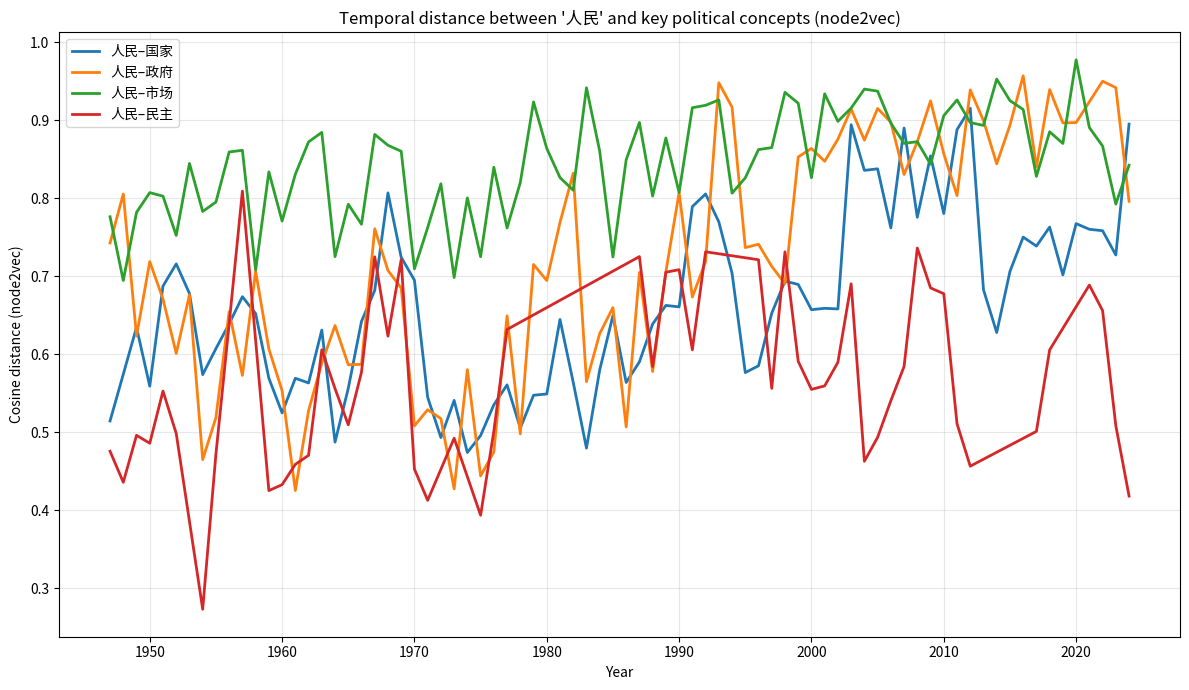

In [ ]:
plt.figure(figsize=(12, 7))

for (w1, w2), (yrs, ds) in series.items():
    # convert to pandas Series so we can interpolate missing values if needed
    s = pd.Series(ds, index=yrs)
    # optional: interpolate NaNs for nicer lines
    s_interp = s.interpolate(limit_direction="both")
    
    plt.plot(
        s_interp.index,
        s_interp.values,
        label=f"{w1}–{w2}",
        linewidth=2
    )

plt.xlabel("Year")
plt.ylabel("Cosine distance (node2vec)")
plt.title("Temporal distance between '人民' and key political concepts (node2vec)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**As the graph shows, the semantic distance between different political concepts and "the people" exhibited significant dynamic changes between 1947 and 2024.**

**Overall, the distance between "the people and the market" remained at the highest level, indicating that in the People's Daily discourse system, "the people" and "the market" were long in relatively separate semantic regions.** This aligns with the narrative structure of Chinese political discourse, which has long focused on the interests of the state, collective, and public, rather than being dominated by market logic.

**In contrast, the distance curves between "the people and the state" and "the people and the government" were relatively close, and generally lower in the early period (1950s–1970s).** This suggests that during this period, "the people" more frequently appeared alongside narratives of the state and government, reflecting a highly politicized collectivist framework. After the reform and opening up, the distance between "the people and the state" and "the people and the government" gradually widened, especially stabilizing at a relatively high level after the 1990s. This implies that with the diversification of governance structures and policy issues, the semantic distance between "the people" and the state/government has increased, and they are no longer as closely bound as in the early stages.

**The "people-democracy" concept exhibits greater volatility than other concepts**: the distance was relatively low in the early period (1950s-1960s), reflecting the frequent appearance of political slogans such as "people's democracy"; the distance increased from the late Cultural Revolution to the early reform period; and then declined after the 2000s. This volatility indicates that the political narrative function of "democracy" varied significantly across different periods, leading to a more phased structural relationship between it and "the people."

In summary, the dynamic trajectory in the figure reflects the shifts in the semantic focus of China's political concept system across different historical stages. **Throughout history, "the people" has maintained a strong connection with the state and government, while maintaining a significant distance from the market; the distance of "democracy," on the other hand, better reflects the volatility of political discourse across different periods.** These temporal structural semantic changes provide more systematic evidence for understanding how the political meaning of the concept of "the people" has been reshaped in different historical stages.

# Reflect on Social/Cultural Implications of your findings

**In conducting this analysis, I gradually realized that Node2Vec is not only a modeling method, but also provides me with a novel, structured exploratory data analysis (EDA) tool.** Due to the massive scale of the People's Daily corpus, its long span across decades, and the significant changes in themes with political cycles, relying solely on word frequency or local similarity from Word2Vec is insufficient to fully understand the overall evolution of semantic structure. Node2Vec, by transforming the annual semantic space into a graph structure and extracting its topological relationships, allows me to more systematically observe the structural positions between words, changes in semantic communities, and the movement trajectory of concepts throughout the semantic network over time. In other words, this experiment validated the feasibility of Node2Vec and demonstrated its significant value for my subsequent in-depth EDA.

**From a social and cultural perspective, the annual semantic distances I obtained reveal the structural shifts in the core political concept of "the people" across different historical stages.** The early "people-state/government" distance was very low, reflecting the ideological characteristic of the people being highly placed within the narrative of state power in the early years of the People's Republic; after the reform and opening up, this distance gradually increased, reflecting the diversification of governance logic and policy issues. The consistently high distance between "people" and "market" indicates that market logic has long been relegated to a relatively marginal position in official political narratives. The strong fluctuations in the "people-democracy" curve further illustrate that the concept of "democracy" has assumed different political functions and symbolic meanings in different historical periods.

These structural trends align closely with existing theories in political communication, conceptual history, and ideology studies, while also providing new analytical pathways for my own research questions. Node2Vec makes the movement trajectory of the concept of "people" in semantic networks quantifiable and observable, enabling me to more directly answer the core question of the project: how has the semantic identity of the concept of "people" been reshaped and adjusted by the state in different political phases from 1947 to 2024? **More importantly, this experiment has confirmed the exploratory value of Node2Vec in large-scale political text corpora, making it an indispensable structural EDA tool in my subsequent research.**